In [ ]:
!pip install plotly
!pip install imgaug 

In [ ]:
!gcsfuse images_bucket ~/data/images
!gcsfuse other_bucket ~/data/other
#!gcsfuse model_bucket ~/model/variables
#!gcsfuse sn_test_bucket ~/sn_test_data
#!gcsfuse sn_train_bucket ~/data/sn_images
#!gcsfuse test_bucket ~/test_data

In [1]:
# tensorflow as base library for neural networks
import tensorflow as tf

# keras as a layer on top of tensorflow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import Sequence
import tensorflow.keras.backend as K

# h5py is needed to store and load Keras models
import h5py
 
# matplotlib is needed to plot bounding boxes
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

import imgaug as ia
from imgaug import augmenters as iaa

from tqdm.notebook import tqdm
import numpy as np
import json
import pickle
import os, cv2, time, random
import ntpath

import utils

import plotly.express as px
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import math
import copy
from utils import BoundBox, normalize, bbox_iou, decode_netout

In [2]:
working_folder = Path("data")
image_folder = working_folder / "images"

hamamatsu_rx_ids = list(range(0, 51))
hamamatsu_360_ids = list(range(51, 101))
aperio_ids = list(range(101, 151))
leica_ids = list(range(151, 201))

In [3]:
annotation_file = working_folder / "other" / "MIDOG.json"
rows = []
with open(annotation_file) as f:
    data = json.load(f)

    categories = {1: 'mitotic figure', 2: 'hard negative'}

    for row in data["images"]:
        file_name = row["file_name"]
        image_id = row["id"]
        width = row["width"]
        height = row["height"]

        scanner  = "Hamamatsu XR"
        if image_id in hamamatsu_360_ids:
            scanner  = "Hamamatsu S360"
        if image_id in aperio_ids:
            scanner  = "Aperio CS"
        if image_id in leica_ids:
            scanner  = "Leica GT450"

        for annotation in [anno for anno in data['annotations'] if anno["image_id"] == image_id]:
            box = annotation["bbox"]
            cat = categories[annotation["category_id"]]

            rows.append([file_name, image_id, width, height, box, cat, scanner])

df = pd.DataFrame(rows, columns=["file_name", "image_id", "width", "height", "box", "cat", "scanner"])
df.tail()

,file_name,image_id,width,height,box,cat,scanner
4430,150.tiff,150,6467,4862,"[569, 4276, 619, 4326]",hard negative,Aperio CS
4431,150.tiff,150,6467,4862,"[3730, 4538, 3780, 4588]",mitotic figure,Aperio CS
4432,150.tiff,150,6467,4862,"[4318, 4138, 4368, 4188]",hard negative,Aperio CS
4433,150.tiff,150,6467,4862,"[5643, 1318, 5693, 1368]",hard negative,Aperio CS
4434,150.tiff,150,6467,4862,"[2681.5, 2846, 2731.5, 2896]",hard negative,Aperio CS


**Make a dictionary with all boxes for each image.**

In [4]:
df['box_with_cat'] = df.apply(lambda row: [row['box'][0], row['box'][1], row['box'][2], row['box'][3], row['cat']], axis = 1)
grouped_boxes_df = df[['image_id', 'box_with_cat']].groupby('image_id').box_with_cat.apply(list).reset_index()
box_dict = grouped_boxes_df.set_index('image_id').T.to_dict('list')
box_dict.get(1)[0]

[[4336, 346, 4386, 396, 'hard negative'],
 [756, 872, 806, 922, 'hard negative'],
 [270, 4044, 320, 4094, 'hard negative'],
 [6672.5, 706.5, 6722.5, 756.5, 'hard negative']]

In [5]:
def get_random_slice_data(width, height, box, box_size, slice_size):
    
    (b_xmin, b_ymin, b_xmax, b_ymax) = box
    
    if b_xmin < 0: b_xmin = 0
    if b_ymin < 0: b_ymin = 0
    if b_xmax > width: b_xmax = width
    if b_ymax > height: b_ymax = height
    
    xmin = random.randint(max(0, int(math.ceil(b_xmax) - slice_size)), min(int(b_xmin), width - slice_size)) 
    ymin = random.randint(max(0, int(math.ceil(b_ymax) - slice_size)), min(int(b_ymin), height - slice_size)) 

    return (xmin, ymin)

In [6]:
def get_boxes_for_slice(slice_xy, slice_size, image_boxes, box_size):
    boxes = []
    for box in image_boxes:
        (b_xmin, b_ymin, _, _, cat) = box
        if ((box[0] > slice_xy[0] - box_size/2 and box[0] < slice_xy[0] + slice_size - box_size/2) and
            (box[1] > slice_xy[1] - box_size/2 and box[1] < slice_xy[1] + slice_size - box_size/2)):
                boxes.append(box)
    return boxes

**Add a random image slice around every entity.**

In [7]:
box_size = 50
slice_size = 256

df["slice"] = df.apply(lambda row: get_random_slice_data(
    row.width,
    row.height,
    row.box,
    box_size,
    slice_size
), axis = 1)

df.head()

,file_name,image_id,width,height,box,cat,scanner,box_with_cat,slice
0,001.tiff,1,7215,5412,"[4336, 346, 4386, 396]",hard negative,Hamamatsu XR,"[4336, 346, 4386, 396, hard negative]","(4233, 317)"
1,001.tiff,1,7215,5412,"[756, 872, 806, 922]",hard negative,Hamamatsu XR,"[756, 872, 806, 922, hard negative]","(577, 831)"
2,001.tiff,1,7215,5412,"[270, 4044, 320, 4094]",hard negative,Hamamatsu XR,"[270, 4044, 320, 4094, hard negative]","(129, 3865)"
3,001.tiff,1,7215,5412,"[6672.5, 706.5, 6722.5, 756.5]",hard negative,Hamamatsu XR,"[6672.5, 706.5, 6722.5, 756.5, hard negative]","(6478, 660)"
4,002.tiff,2,7215,5412,"[1872, 319, 1922, 369]",hard negative,Hamamatsu XR,"[1872, 319, 1922, 369, hard negative]","(1826, 210)"


**Get other boxes that also fit into a random slice.**

In [8]:
df["slice_boxes"] = df.apply(lambda row: get_boxes_for_slice(
    row.slice,
    slice_size,
    box_dict.get(row.image_id)[0],
    box_size,
), axis = 1)

df.head()

,file_name,image_id,width,height,box,cat,scanner,box_with_cat,slice,slice_boxes
0,001.tiff,1,7215,5412,"[4336, 346, 4386, 396]",hard negative,Hamamatsu XR,"[4336, 346, 4386, 396, hard negative]","(4233, 317)","[[4336, 346, 4386, 396, hard negative]]"
1,001.tiff,1,7215,5412,"[756, 872, 806, 922]",hard negative,Hamamatsu XR,"[756, 872, 806, 922, hard negative]","(577, 831)","[[756, 872, 806, 922, hard negative]]"
2,001.tiff,1,7215,5412,"[270, 4044, 320, 4094]",hard negative,Hamamatsu XR,"[270, 4044, 320, 4094, hard negative]","(129, 3865)","[[270, 4044, 320, 4094, hard negative]]"
3,001.tiff,1,7215,5412,"[6672.5, 706.5, 6722.5, 756.5]",hard negative,Hamamatsu XR,"[6672.5, 706.5, 6722.5, 756.5, hard negative]","(6478, 660)","[[6672.5, 706.5, 6722.5, 756.5, hard negative]]"
4,002.tiff,2,7215,5412,"[1872, 319, 1922, 369]",hard negative,Hamamatsu XR,"[1872, 319, 1922, 369, hard negative]","(1826, 210)","[[1872, 319, 1922, 369, hard negative]]"


**Save each slice to disk, so the model doesn't need to open every time the whole image for each slice.**

In [9]:
def parse_annotation(df, img_dir, train_dir, slice_size):
    all_imgs = []
    seen_labels = {}
    
    for i in range(1, 151):
        if i in [30, 60, 90, 120]:
            print(i, "finished!")
        
        temp_df = df[df['image_id'] == i]
        #temp_name = 'output' + str(i) + '.tiff'
        temp_name = temp_df.iloc[0][0]
         
        temp_image = cv2.imread(img_dir + temp_name)
    
        for index, row in temp_df.iterrows():

            img = {'object':[]}

            _, _, _, _, _, _, _, _, im_slice, slice_boxes = row

            image = temp_image[im_slice[1]:im_slice[1]+slice_size, im_slice[0]:im_slice[0]+slice_size]
            train_name = str(index) + '.tiff'
            cv2.imwrite(train_dir + train_name, image)

            img['file_name'] = train_dir + train_name
            img['width'] = slice_size
            img['height'] = slice_size

            for box in slice_boxes:
                (b_xmin, b_ymin, b_xmax, b_ymax, cat) = box
                obj = {}
                obj['name'] = cat
                img['object'] += [obj]

                obj['xmin'] = b_xmin - im_slice[0]
                obj['ymin'] = b_ymin - im_slice[1]
                obj['xmax'] = b_xmax - im_slice[0]
                obj['ymax'] = b_ymax - im_slice[1]

            if len(img['object']) > 0:
                all_imgs += [img]
        
    return all_imgs

In [10]:
image_path = os.path.join('./', 'data', 'images/')
train_path = os.path.join('./', 'data', 'train/')
all_imgs = parse_annotation(df, image_path, train_path, slice_size)

30 finished!
60 finished!
90 finished!
120 finished!


In [11]:
LABELS = ['hard negative', 'mitotic figure']

CLASS            = len(LABELS)
CLASS_WEIGHTS    = np.ones(CLASS, dtype='float32')

IMAGE_H, IMAGE_W = slice_size, slice_size
GRID_H,  GRID_W  = 16 , 16
BOX              = 5
OBJ_THRESHOLD    = 0.3
NMS_THRESHOLD    = 0.1
ANCHORS          = [2.2, 2.2, 2.7, 2.7, 3.2, 3.2, 3.7, 3.7, 4.2, 4.2]

NO_OBJECT_SCALE  = 1.0
OBJECT_SCALE     = 5.0
COORD_SCALE      = 1.0
CLASS_SCALE      = 1.0

BATCH_SIZE       = 32
WARM_UP_BATCHES  = 100
TRUE_BOX_BUFFER  = 50

In [12]:
generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'BOX'             : BOX,
    'LABELS'          : LABELS,
    'CLASS'           : len(LABELS),
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : 50,
}

In [13]:
def space_to_depth_x2(x):
    return tf.nn.space_to_depth(x, block_size=2)

In [14]:
def YOLO_network(input_img,true_bxs,CLASS):

    # Layer 1
    x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_img)
    x = BatchNormalization(name='norm_1')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 2
    x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
    x = BatchNormalization(name='norm_2')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 3
    x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
    x = BatchNormalization(name='norm_3')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 4
    x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
    x = BatchNormalization(name='norm_4')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 5
    x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
    x = BatchNormalization(name='norm_5')(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    
    # Layer 6
    x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
    x = BatchNormalization(name='norm_6')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 7
    x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
    x = BatchNormalization(name='norm_7')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 8
    x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False, input_shape=(512,512,3))(x)
    x = BatchNormalization(name='norm_8')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 9
    x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
    x = BatchNormalization(name='norm_9')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 10
    x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
    x = BatchNormalization(name='norm_10')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 11
    x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
    x = BatchNormalization(name='norm_11')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 12
    x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
    x = BatchNormalization(name='norm_12')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 13
    x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
    x = BatchNormalization(name='norm_13')(x)
    x = LeakyReLU(alpha=0.1)(x)

    skip_connection = x

    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Layer 14
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
    x = BatchNormalization(name='norm_14')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 15
    x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
    x = BatchNormalization(name='norm_15')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 16
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
    x = BatchNormalization(name='norm_16')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 17
    x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
    x = BatchNormalization(name='norm_17')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 18
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
    x = BatchNormalization(name='norm_18')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 19
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
    x = BatchNormalization(name='norm_19')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 20
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
    x = BatchNormalization(name='norm_20')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 21
    skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
    skip_connection = BatchNormalization(name='norm_21')(skip_connection)
    skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
    skip_connection = Lambda(space_to_depth_x2)(skip_connection)

    x = concatenate([skip_connection, x])

    # Layer 22
    x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
    x = BatchNormalization(name='norm_22')(x)
    x = LeakyReLU(alpha=0.1)(x)

    # Layer 23
    x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
    output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)
    output = Lambda(lambda args: args[0])([output, true_bxs])

    model = Model([input_img, true_bxs], output)
    
    model.summary()
    
    return model

In [15]:
input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))

model = YOLO_network(input_image, true_boxes, CLASS)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 256, 256, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 256, 256, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256, 256, 32) 0           norm_1[0][0]                     
_______________________________________________________________________________________

In [16]:
def predict_bounding_box(image, model, obj_threshold, nms_threshold, anchors, nb_class):
    """
        Predict bounding boxes for a given image.
    """    
    input_image = image / 255. # rescale intensity to [0, 1]
    input_image = input_image[:,:,::-1]
    img_shape = image.shape
    input_image = np.expand_dims(input_image, 0) 

    # define variable needed to process input image
    dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

    # get output from network
    netout = model.predict([input_image, dummy_array])
    
    return utils.decode_netout(netout[0], obj_threshold, nms_threshold, anchors, nb_class)    

In [17]:
import numpy as np
import tensorflow as tf
from loss_utils import *

class Loss(tf.keras.losses.Loss):

    EPSILON = 1e-6

    def __init__(
        self,
        batch_size,
        grid_width,
        grid_height,
        anchors,
        n_boxes=1000,
        scales=Scales()
    ):

        self._batch_size = batch_size
        self._grid_width = grid_width
        self._grid_height = grid_height

        self._n_boxes = n_boxes
        self._anchors = anchors
        self._scales = scales

        self._grid = get_cell_grid(
            self._batch_size, self._n_boxes, self._grid_width, self._grid_height
        )
        
        self.reduction = tf.keras.losses.Reduction.AUTO
        self.name = 'loss'

    def __call__(self, y_true, y_pred, sample_weight=None):

        # prediction
        pred_box_xy = tf.sigmoid(y_pred[..., :2]) + self._grid
        pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(
            self._anchors, [1, 1, 1, self._n_boxes, 2]
        )
        pred_box_conf = tf.sigmoid(y_pred[..., 4])
        pred_box_class = y_pred[..., 5:]

        # ground thuth
        true_box_xy = y_true[..., :2]
        true_box_wh = y_true[..., 2:4]
        true_box_conf = (
            tf_iou(true_box_xy, true_box_wh, pred_box_xy, pred_box_wh) * y_true[..., 4]
        )
        true_box_class = tf.argmax(y_true[..., 5:], -1)

        # masks
        # TODO calculate responsible anchorbox (not neccesary when one anchor box)

        # expand for  2 values (x,y) and (w,h) for coord scale
        coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * self._scales.coord_scale
        conf_mask = (y_true[..., 4] + self._scales.no_object_scale) * self._scales.object_scale
        class_mask = y_true[..., 4] * self._scales.class_scale

        # normalization factor
        nb_coord_norm = tf.reduce_sum(tf.cast(coord_mask > 0.0, dtype=tf.float32)) + Loss.EPSILON
        nb_conf_norm = tf.reduce_sum(tf.cast(conf_mask > 0.0, dtype=tf.float32)) + Loss.EPSILON
        nb_class_norm = tf.reduce_sum(tf.cast(class_mask > 0.0, dtype=tf.float32)) + Loss.EPSILON

        # losses
        loss_xy = (
            tf.reduce_sum(tf.square(true_box_xy - pred_box_xy) * coord_mask)
            / nb_coord_norm
            / 2.0
        )
        loss_wh = (
            tf.reduce_sum(tf.square(true_box_wh - pred_box_wh) * coord_mask)
            / nb_coord_norm
            / 2.0
        )
        loss_conf = (
            tf.reduce_sum(tf.square(true_box_conf - pred_box_conf) * conf_mask)
            / nb_conf_norm
            / 2.0
        )
        loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=true_box_class, logits=pred_box_class
        )
        loss_class = tf.reduce_sum(loss_class * class_mask) / nb_class_norm

        # combine all terms
        loss = loss_xy + loss_wh + loss_conf + loss_class
        return loss

In [18]:
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.001, 
                           patience=10, 
                           mode='min', 
                           verbose=1)

checkpoint = ModelCheckpoint('best_model.h5',
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             period=1)

In [19]:
class BatchGenerator(Sequence):
    def __init__(self, images,
                       config,
                       shuffle=True,
                       jitter=True,
                       norm=None):
        self.generator = None

        self.images = images
        self.config = config

        self.shuffle = shuffle
        self.jitter  = jitter
        self.norm    = norm

        self.counter = 0
        self.anchors = [BoundBox(0, 0, config['ANCHORS'][2*i], config['ANCHORS'][2*i+1]) for i in range(int(len(config['ANCHORS'])//2))]

        ### augmentors by https://github.com/aleju/imgaug
        sometimes = lambda aug: iaa.Sometimes(0.5, aug)

        # Define our sequence of augmentation steps that will be applied to every image
        self.aug_pipe = iaa.Sequential(
            [
                iaa.SomeOf((0, 5),
                    [
                        iaa.OneOf([
                            iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                            iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                            iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                        ]),
                        iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                        iaa.OneOf([
                            iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                        ]),
                        iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                        iaa.Multiply((0.5, 1.5), per_channel=0.5), # change brightness of images (50-150% of original value)
                        iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                    ],
                    random_order=True
                )
            ],
            random_order=True
        )

        if shuffle: np.random.shuffle(self.images)

    def __len__(self):
        return int(np.ceil(float(len(self.images))/self.config['BATCH_SIZE']))

    def __getitem__(self, idx):
        l_bound = idx*self.config['BATCH_SIZE']
        r_bound = (idx+1)*self.config['BATCH_SIZE']

        if r_bound > len(self.images):
            r_bound = len(self.images)
            l_bound = r_bound - self.config['BATCH_SIZE']

        instance_count = 0

        x_batch = np.zeros((r_bound - l_bound, self.config['IMAGE_H'], self.config['IMAGE_W'], 3))
        b_batch = np.zeros((r_bound - l_bound, 1     , 1     , 1    ,  self.config['TRUE_BOX_BUFFER'], 4))
        y_batch = np.zeros((r_bound - l_bound, self.config['GRID_H'],  self.config['GRID_W'], self.config['BOX'], 4+1+self.config['CLASS']))

        for train_instance in self.images[l_bound:r_bound]:
            # augment input image and fix object's position and size
            img, all_objs = self.aug_image(train_instance, jitter=self.jitter)

            # construct output from object's x, y, w, h
            true_box_index = 0

            for obj in all_objs:
                if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin'] and obj['name'] in self.config['LABELS']:
                    center_x = .5*(obj['xmin'] + obj['xmax'])
                    center_x = center_x / (float(self.config['IMAGE_W']) / self.config['GRID_W'])
                    center_y = .5*(obj['ymin'] + obj['ymax'])
                    center_y = center_y / (float(self.config['IMAGE_H']) / self.config['GRID_H'])

                    grid_x = int(np.floor(center_x))
                    grid_y = int(np.floor(center_y))

                    if grid_x < self.config['GRID_W'] and grid_y < self.config['GRID_H']:
                        obj_indx  = self.config['LABELS'].index(obj['name'])

                        center_w = (obj['xmax'] - obj['xmin']) / (float(self.config['IMAGE_W']) / self.config['GRID_W']) # unit: grid cell
                        center_h = (obj['ymax'] - obj['ymin']) / (float(self.config['IMAGE_H']) / self.config['GRID_H']) # unit: grid cell

                        box = [center_x, center_y, center_w, center_h]

                        # find the anchor that best predicts this box
                        best_anchor = -1
                        max_iou     = -1

                        shifted_box = BoundBox(0,
                                               0,
                                               center_w,
                                               center_h)

                        for i in range(len(self.anchors)):
                            anchor = self.anchors[i]
                            iou    = bbox_iou(shifted_box, anchor)

                            if max_iou < iou:
                                best_anchor = i
                                max_iou     = iou

                        # assign ground truth x, y, w, h, confidence and class probs to y_batch
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 0:4] = box
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 4  ] = 1.
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 5+obj_indx] = 1

                        # assign the true box to b_batch
                        b_batch[instance_count, 0, 0, 0, true_box_index] = box

                        true_box_index += 1
                        true_box_index = true_box_index % self.config['TRUE_BOX_BUFFER']

            # assign input image to x_batch
            if self.norm != None:
                x_batch[instance_count] = self.norm(img)
            else:
                # plot image and bounding boxes for sanity check
                for obj in all_objs:
                    if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin']:
                        cv2.rectangle(img[:,:,::-1], (obj['xmin'],obj['ymin']), (obj['xmax'],obj['ymax']), (255,0,0), 3)
                        cv2.putText(img[:,:,::-1], obj['name'],
                                    (obj['xmin']+2, obj['ymin']+12),
                                    0, 1.2e-3 * img.shape[0],
                                    (0,255,0), 2)

                x_batch[instance_count] = img

            # increase instance counter in current batch
            instance_count += 1

        self.counter += 1

        return [x_batch, b_batch], y_batch

    def on_epoch_end(self):
        if self.shuffle: np.random.shuffle(self.images)
        self.counter = 0

    def aug_image(self, train_instance, jitter):
        image_name = train_instance['file_name']
        image = cv2.imread(image_name)
        
        h, w, c = image.shape

        all_objs = copy.deepcopy(train_instance['object'])

        if jitter:
            ### scale the image
            scale = np.random.uniform() / 10. + 1.
            image = cv2.resize(image, (0,0), fx = scale, fy = scale)

            ### translate the image
            max_offx = (scale-1.) * w
            max_offy = (scale-1.) * h
            offx = int(np.random.uniform() * max_offx)
            offy = int(np.random.uniform() * max_offy)

            image = image[offy : (offy + h), offx : (offx + w)]

            ### flip the image
            flip = np.random.binomial(1, .5)
            if flip > 0.5: image = cv2.flip(image, 1)

            #image = self.aug_pipe.augment_image(image)

        # resize the image to standard size
        image = cv2.resize(image, (self.config['IMAGE_H'], self.config['IMAGE_W']))
        image = image[:,:,::-1]

        # fix object's position and size
        for obj in all_objs:
            for attr in ['xmin', 'xmax']:
                if jitter: obj[attr] = int(obj[attr] * scale - offx)

                obj[attr] = int(obj[attr] * float(self.config['IMAGE_W']) / w)
                obj[attr] = max(min(obj[attr], self.config['IMAGE_W']), 0)

            for attr in ['ymin', 'ymax']:
                if jitter: obj[attr] = int(obj[attr] * scale - offy)

                obj[attr] = int(obj[attr] * float(self.config['IMAGE_H']) / h)
                obj[attr] = max(min(obj[attr], self.config['IMAGE_H']), 0)

            if jitter and flip > 0.5:
                xmin = obj['xmin']
                obj['xmin'] = self.config['IMAGE_W'] - obj['xmax']
                obj['xmax'] = self.config['IMAGE_W'] - xmin

        return image, all_objs

In [20]:
training_data_percentage = 0.95
train_valid_split = int(training_data_percentage * len(all_imgs))

train_batch = BatchGenerator(all_imgs[:train_valid_split], generator_config, norm=utils.normalize)
valid_batch = BatchGenerator(all_imgs[train_valid_split:], generator_config, norm=utils.normalize)

/opt/conda/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


In [21]:
import requests
import zipfile
link = 'https://surfdrive.surf.nl/files/index.php/s/HGmdukdYpnyt2NV/download'
file_name = "pretrained_yolo_weights.zip"
with open(file_name, "wb") as f:
        response = requests.get(link, stream=True)
        total_length = response.headers.get('content-length')
        if total_length is None: # no content length header
            f.write(response.content)
        else:
            dl = 0
            total_length = int(total_length)
            for data in tqdm(response.iter_content(chunk_size=4096), desc='Downloading data'):
                dl += len(data)
                f.write(data)
with zipfile.ZipFile(file_name,"r") as zip_ref:
    zip_ref.extractall("./")
os.remove('./pretrained_yolo_weights.zip')

In [22]:
# path to file of Pascal VOC YOLO weights
wt_path = os.path.join(os.getcwd(), './pretrained_yolo_weights.h5')
model.load_weights(wt_path)
print("Weights loaded from disk")

Weights loaded from disk


In [ ]:
# path to best model
#from tensorflow import keras
#model = keras.models.load_model('model')
#print("Weights loaded from disk")

In [23]:
n_epoch = 10
learning_rate = 1e-5

optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.99, epsilon=1e-08, decay=0.0)

loss = Loss(BATCH_SIZE, GRID_H, GRID_W, ANCHORS, n_boxes = 5)
model.compile(loss=loss, optimizer=optimizer)

history = model.fit(train_batch,
            validation_data = valid_batch,
            epochs=n_epoch,
            callbacks=[early_stop, checkpoint])

Epoch 1/10
132/132 [==============================] - ETA: 0s - loss: 0.9926
Epoch 00001: val_loss improved from inf to 0.99074, saving model to best_model.h5
132/132 [==============================] - 84s 633ms/step - loss: 0.9926 - val_loss: 0.9907
Epoch 2/10
132/132 [==============================] - ETA: 0s - loss: 0.7018
Epoch 00002: val_loss improved from 0.99074 to 0.69631, saving model to best_model.h5
132/132 [==============================] - 88s 665ms/step - loss: 0.7018 - val_loss: 0.6963
Epoch 3/10
132/132 [==============================] - ETA: 0s - loss: 0.5266
Epoch 00003: val_loss improved from 0.69631 to 0.57184, saving model to best_model.h5
132/132 [==============================] - 89s 675ms/step - loss: 0.5266 - val_loss: 0.5718
Epoch 4/10
132/132 [==============================] - ETA: 0s - loss: 0.4294
Epoch 00004: val_loss improved from 0.57184 to 0.55961, saving model to best_model.h5
132/132 [==============================] - 90s 682ms/step - loss: 0.4294 - v

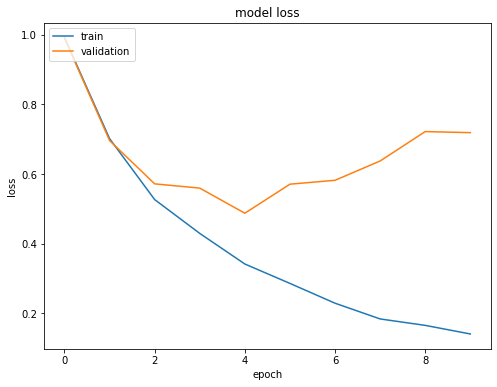

In [24]:
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [25]:
model.load_weights('best_model.h5')

In [26]:
def slice_image(image, slice_size):
    slices = []
    
    h, w, _ = image.shape
    slices_y = math.ceil(h / slice_size)
    slices_x = math.ceil(w / slice_size)
    
    for y in range(slices_y):
        for x in range(slices_x):

            x_min = x * slice_size
            y_min = y * slice_size

            if x_min + slice_size > w: x_min = w - slice_size
            if y_min + slice_size > h: y_min = h - slice_size

            slices.append((x_min, y_min))
    
    return slices

**Find the best threshold for all (or a part of) images.**

In [27]:
image_path = os.path.join('./', 'data', 'images/')
#num_list = range(1, 151)
num_list = random.sample(range(1, 151), 15)

In [28]:
f1_scores = []
thresholds = np.arange(0.1, 0.4, 0.003)
slice_size = 256

for im_n in num_list:

    w = 2000
    h = 2000
    image = cv2.imread(image_path + str(im_n).zfill(3) + '.tiff')
    #image = image[0:h, 0:w]
    
    true_data = df.loc[df['image_id'] == im_n]['box'].tolist()
    boxes = []
    
    obj_threshold=thresholds[0]
    slices = slice_image(image, slice_size)
    h, w, _ = image.shape

    for slice_xy in slices:
        image_slice = image[slice_xy[1]:slice_xy[1]+slice_size, slice_xy[0]:slice_xy[0]+slice_size]
        slice_boxes = predict_bounding_box(image_slice, model, obj_threshold, NMS_THRESHOLD, ANCHORS, CLASS)
        slice_boxes = [box for box in slice_boxes if box.label == 1]
        for slice_box in slice_boxes:
            slice_box.x = slice_size / w * slice_box.x + slice_xy[0] / w
            slice_box.y = slice_size / h * slice_box.y + slice_xy[1] / h
        boxes = boxes + slice_boxes

    for box in boxes:
        box.x = w * box.x
        box.y = h * box.y

    to_remove = []
    for i, box_1 in enumerate(boxes):
        for box_2 in boxes:
            if ((box_1.x < box_2.x + box_size*1.5 and box_1.x > box_2.x - box_size*1.5) and
                (box_1.y < box_2.y + box_size*1.5 and box_1.y > box_2.y - box_size*1.5) and
                box_1.score < box_2.score):
                    to_remove.append(i)

    for index in sorted(set(to_remove), reverse=True):
        del boxes[index]
    
    f1 = []
    for obj_threshold in thresholds:

        slice_boxes = [box for box in boxes if box.score > obj_threshold]
        positives = []
        for i, box_1 in enumerate(slice_boxes):
            for j, box_2 in enumerate(true_data):
                if ((box_1.x < box_2[0] + 3/2 * box_size and box_1.x > box_2[0] - 0.5 * box_size) and
                    (box_1.y < box_2[1] + 3/2 * box_size and box_1.y > box_2[1] - 0.5 * box_size)):
                        positives.append(i)
        total = len(slice_boxes)
        if total == 0: total = -1
        precision = len(set(positives)) / total
        recall = len(set(positives)) / 6
        if (precision + recall) == 0 : precision = -1
        f1.append(2 * (precision * recall) / (precision + recall))
    
    f1_scores.append(f1)

In [29]:
avg_f1 = np.mean(f1_scores, axis=0)
best_threshold = thresholds[np.where(avg_f1 == np.amax(avg_f1))[0][0]]
best_threshold

0.16100000000000003

**Make predictions for test data using the best model and its best threshold.**

In [30]:
def bbox2csv(image_n, boxes, csv_file):
    
    csv_out = open(csv_file, 'a')
    
    slide = str(image_n).zfill(2)
    
    for box in boxes:
        
        line = slide + ',' + str(round(box.x)) + ',' + str(round(box.y))
        csv_out.write(line + '\n')

    csv_out.close()

In [31]:
out_dir = './output'
#test_dir = os.path.join('./','sn_test_data/')
test_dir = os.path.join('./','test_data/')
file_name = 'output'

slice_size = 256
obj_threshold = best_threshold

header = 'slide, x, y\n'
csv_file = os.path.join(out_dir,'result.csv')

with open(csv_file, 'w') as csv_out:
    csv_out.write(header)

for image_n in range(1, 35):
    
    boxes = []
    #image_name = file_name + str(image_n) + '.tiff'
    image_name = str(image_n).zfill(2) + '.tif' 
    image = cv2.imread(test_dir + image_name)
    slices = slice_image(image, slice_size)
    h, w, _ = image.shape

    for slice_xy in slices:
        image_slice = image[slice_xy[1]:slice_xy[1]+slice_size, slice_xy[0]:slice_xy[0]+slice_size]
        slice_boxes = predict_bounding_box(image_slice, model, obj_threshold, NMS_THRESHOLD, ANCHORS, CLASS)
        slice_boxes = [box for box in slice_boxes if box.label == 1]
        for slice_box in slice_boxes:
            slice_box.x = slice_size / w * slice_box.x + slice_xy[0] / w
            slice_box.y = slice_size / h * slice_box.y + slice_xy[1] / h
        boxes = boxes + slice_boxes
    
    for box in boxes:
        box.x = w * box.x
        box.y = h * box.y
    
    to_remove = []
    for i, box_1 in enumerate(boxes):
        for box_2 in boxes:
            if ((box_1.x < box_2.x + box_size*1.5 and box_1.x > box_2.x - box_size*1.5) and
                (box_1.y < box_2.y + box_size*1.5 and box_1.y > box_2.y - box_size*1.5) and
                box_1.score < box_2.score):
                    to_remove.append(i)

    for index in sorted(set(to_remove), reverse=True):
        del boxes[index]
        
    bbox2csv(image_n, boxes, csv_file)
    if image_n in [1, 10, 20, 30]:
        print(image_n, 'finished!')

1 finished!
10 finished!
20 finished!
30 finished!
